# Presets

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astroquery.gaia import Gaia
from matplotlib.patches import Circle

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm  # Import tqdm for progress bar
import re  # To use regular expressions for suffix handling
import csv

import concurrent.futures
import time

import ast  # To safely evaluate the string representation of lists

from IPython.display import display, HTML

# Load the matched_catalogue_full.csv
matched_catalogue_full = pd.read_csv('matched_catalogue_full.csv', dtype={'source_id': str})

Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Monday the 3rd of March from 09:00 to 11:00


In [5]:
# Load the exoplanet catalogue
exoplanet_catalogue = pd.read_csv('exoplanet_catalogue_2.csv')  # Exoplanet catalogue from local CSV
print(f"Exoplanet catalogue loaded with {len(exoplanet_catalogue)} entries.")

# exoplanet_catalogue = exoplanet_catalogue.dropna(subset=['ra', 'dec'])  # Remove rows with missing RA/DEC
print(f"Exoplanet catalogue loaded with {len(exoplanet_catalogue)} entries.")

Exoplanet catalogue loaded with 7380 entries.
Exoplanet catalogue loaded with 7380 entries.


# Gaia identifiers search with SIMBAD
First, we perform a search for the Gaia identifiers (source_id) through the SIMBAD website.

In [71]:
# Function to get Gaia ID from SIMBAD
def get_simbad_data(star_name):
    base_url = "http://simbad.u-strasbg.fr/simbad/sim-basic?"
    params = {'Ident': star_name}
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        for link in soup.find_all('a'):
            if "Gaia DR3" in link.text:
                return link.text.strip().split(" ")[-1], True  # Found object in SIMBAD
    return None, False  # Object not found in SIMBAD

# Function to remove suffix after the last space or parenthesis
def remove_suffix(star_name):
    return re.sub(r'(\s\([^\)]*\)|\s[A-Z]+$|\s[a-z]$)', '', star_name) if isinstance(star_name, str) else star_name

# Number of exoplanets to process
exoplanets_indice = len(matched_catalogue_full)  # Process all rows
# exoplanets_indice = 35
stars_with_gaia_id = 0

# Process all exoplanets in the catalogue
for i in tqdm(range(exoplanets_indice), total=exoplanets_indice, desc="Processing stars"):
    # Skip planet if gaia_identifier is already True
    if matched_catalogue_full.at[i, 'gaia_identifier']:
        continue

    star = matched_catalogue_full.iloc[i]['star_name']  # Get the star name
    gaia_id, found_in_simbad = get_simbad_data(star)

    if not gaia_id:
        # Try alternate names if no Gaia ID found
        star_alternate_names = matched_catalogue_full.iloc[i]['star_alternate_names']
        if pd.notna(star_alternate_names):
            alt_names_list = [name.strip() for name in star_alternate_names.split(',') if name.strip()]
            for alt_name in alt_names_list:
                gaia_id, found_in_simbad = get_simbad_data(alt_name)
                if gaia_id:
                    break

    # Try removing suffix if still no match
    if not gaia_id:
        star_no_suffix = remove_suffix(star)
        if star_no_suffix != star:
            gaia_id, found_in_simbad = get_simbad_data(star_no_suffix)

    # Try alternate names
    if not gaia_id:
        alternate_names = matched_catalogue_full.iloc[i]['alternate_names']
        if pd.notna(alternate_names):
            alt_names_list_2 = [name.strip() for name in alternate_names.split(',') if name.strip()]
            for alt_name_2 in alt_names_list_2:
                gaia_id, found_in_simbad = get_simbad_data(alt_name_2)
                if gaia_id:
                    break

    # Try alternate names with suffix removal
    if not gaia_id:
        alternate_names = matched_catalogue_full.iloc[i]['alternate_names']
        if pd.notna(alternate_names):
            alt_names_list_2 = [name.strip() for name in alternate_names.split(',') if name.strip()]
            for alt_name_2 in alt_names_list_2:
                alt_name_2_no_suffix = remove_suffix(alt_name_2)
                if alt_name_2_no_suffix != alt_name_2:
                    gaia_id, found_in_simbad = get_simbad_data(alt_name_2_no_suffix)
                if gaia_id:
                    break

    # Try with 'name' column
    if not gaia_id:
        planet_name = matched_catalogue_full.iloc[i]['name']
        if pd.notna(planet_name):
            gaia_id, found_in_simbad = get_simbad_data(planet_name)

    # Try removing suffix from 'name' column
    if not gaia_id and pd.notna(planet_name):
        planet_name_no_suffix = remove_suffix(planet_name)
        if planet_name_no_suffix != planet_name:
            gaia_id, found_in_simbad = get_simbad_data(planet_name_no_suffix)

    # Determine the final value of source_id
    if not gaia_id:
        matched_catalogue_full.at[i, 'source_id'] = "no Gaia id" if found_in_simbad else "not found"
    else:
        matched_catalogue_full.at[i, 'source_id'] = gaia_id
        matched_catalogue_full.at[i, 'gaia_identifier'] = True  # Mark as matched
        stars_with_gaia_id += 1
    
# Save the updated matched catalog
matched_catalogue_full['source_id'] = matched_catalogue_full['source_id'].astype(str)
matched_catalogue_full.to_csv('matched_catalogue_full.csv', index=False, quoting=csv.QUOTE_ALL)

# Print results
print("\nMatched catalog saved to 'matched_catalogue_full.csv'.")
print("\nMatched Catalog with Gaia IDs:")
print(matched_catalogue_full[['name', 'star_name', 'source_id']].head(exoplanets_indice))
print(f"\nNumber of stars with Gaia DR3 ID found: {stars_with_gaia_id} out of {exoplanets_indice}")

Processing stars: 100%|██████████| 7380/7380 [29:44<00:00,  4.14it/s] 



Matched catalog saved to 'matched_catalogue_full.csv'.

Matched Catalog with Gaia IDs:
                   name         star_name            source_id
0             109 Psc b           109 Psc    95652018353917056
1             112 Psc b           112 Psc  2511794495013074048
2             112 Psc c           112 Psc  2511794495013074048
3             11 Com Ab          11 Com A  3946945413106333696
4              11 UMi b            11 UMi  1696798367260229376
...                 ...               ...                  ...
7375     ZTF J0407-00 b      ZTF J0407-00  3253845886052817536
7376  ZTF J1406+1222 Ab  ZTF J1406+1222 A            not found
7377     ZTF J1622+47 b      ZTF J1622+47  1410860511508492288
7378     ZTF J1637+49 b      ZTF J1637+49  1410739870171621504
7379     ZTF J2252-05 b      ZTF J2252-05  2612053222273626752

[7380 rows x 3 columns]

Number of stars with Gaia DR3 ID found: 13 out of 7380


# Search for parallax, RV and [M/H] in Gaia
Once we have the Gaia identificators (source_id) for all the exoplanets in matched_catalogue_full.csv, we find parallax, RV and metalicity in the Gaia archive.

In [72]:
# Define the number of objects to process
objects_to_process = len(matched_catalogue_full)

# Function to query Gaia for source data (parallax, RV)
def query_source_data(source_id):
    query_source = f"""
    SELECT 
        source_id, parallax, parallax_error, radial_velocity, radial_velocity_error
    FROM gaiadr3.gaia_source 
    WHERE source_id = {source_id}
    """
    job_source = Gaia.launch_job(query_source)
    return job_source.get_results()

# Function to query Gaia for astrophysical parameters (metallicity, errors)
def query_astro_data(source_id):
    query_astro = f"""
    SELECT 
        source_id, mh_gspphot, mh_gspphot_upper, mh_gspphot_lower
    FROM gaiadr3.astrophysical_parameters
    WHERE source_id = {source_id}
    """
    job_astro = Gaia.launch_job(query_astro)
    return job_astro.get_results()

def process_data(i, matched_catalogue_full):
    source_id = matched_catalogue_full.iloc[i]['source_id']
    
    # Check if the cross-match is True; if so, skip this planet
    if matched_catalogue_full.at[i, 'cross-match']:
        return None

    # Check if the source_id is 'not found' or 'no Gaia id'
    if source_id in ['not found', 'no Gaia id']:
        print(f"Skipping planet {i + 1} because {source_id}.")
        return None

    # Query the Gaia data
    result_source = query_source_data(source_id)
    result_astro = query_astro_data(source_id)

    # Extract the values for parallax, errors, RV if available
    parallax = result_source['parallax'][0] if 'parallax' in result_source.columns else None
    parallax_error = result_source['parallax_error'][0] if 'parallax_error' in result_source.columns else None
    RV = result_source['radial_velocity'][0] if 'radial_velocity' in result_source.columns else None
    RV_error = result_source['radial_velocity_error'][0] if 'radial_velocity_error' in result_source.columns else None

    # Extract the values for metallicity and errors if available
    if len(result_astro) > 0:
        metallicity = result_astro['mh_gspphot'][0] if 'mh_gspphot' in result_astro.columns else None
        mh_upper = result_astro['mh_gspphot_upper'][0] if 'mh_gspphot_upper' in result_astro.columns else None
        mh_lower = result_astro['mh_gspphot_lower'][0] if 'mh_gspphot_lower' in result_astro.columns else None
    else:
        metallicity = None
        mh_upper = None
        mh_lower = None
    
    return (parallax, parallax_error, RV, RV_error, metallicity, mh_lower, mh_upper)

# Loop through the first 'objects_to_process' rows in the matched catalog
for i in range(objects_to_process):
    data = process_data(i, matched_catalogue_full)

    if data:  # Only update if data was found
        parallax, parallax_error, RV, RV_error, metallicity, mh_lower, mh_upper = data
        
        # Update the matched_catalogue_full DataFrame with the retrieved values
        matched_catalogue_full.at[i, 'parallax'] = parallax if parallax is not None else '--'
        matched_catalogue_full.at[i, 'parallax error'] = parallax_error if parallax_error is not None else '--'
        matched_catalogue_full.at[i, 'RV'] = RV if RV is not None else '--'
        matched_catalogue_full.at[i, 'RV error'] = RV_error if RV_error is not None else '--'
        matched_catalogue_full.at[i, '[M/H]'] = metallicity if metallicity is not None else '--'
        matched_catalogue_full.at[i, '[M/H] lower'] = mh_lower if mh_lower is not None else '--'
        matched_catalogue_full.at[i, '[M/H] upper'] = mh_upper if mh_upper is not None else '--'

        # Once calculations are done, mark cross-match as True
        matched_catalogue_full.at[i, 'cross-match'] = True

    # Print the number of the processed planet
    print(f"Processed planet {i + 1} out of {objects_to_process}")

# Save the updated catalog back to CSV
matched_catalogue_full.to_csv('matched_catalogue_full.csv', index=False, quoting=csv.QUOTE_ALL)
print("Matched catalog updated with Gaia data.")

Processed planet 1 out of 7380
Processed planet 2 out of 7380
Processed planet 3 out of 7380
Processed planet 4 out of 7380
Processed planet 5 out of 7380
Processed planet 6 out of 7380
Processed planet 7 out of 7380
Processed planet 8 out of 7380
Processed planet 9 out of 7380
Processed planet 10 out of 7380
Processed planet 11 out of 7380
Processed planet 12 out of 7380
Processed planet 13 out of 7380
Processed planet 14 out of 7380
Processed planet 15 out of 7380
Skipping planet 16 because not found.
Processed planet 16 out of 7380
Processed planet 17 out of 7380
Processed planet 18 out of 7380
Processed planet 19 out of 7380
Processed planet 20 out of 7380
Processed planet 21 out of 7380
Processed planet 22 out of 7380
Processed planet 23 out of 7380
Processed planet 24 out of 7380
Skipping planet 25 because not found.
Processed planet 25 out of 7380
Processed planet 26 out of 7380
Skipping planet 27 because not found.
Processed planet 27 out of 7380
Skipping planet 28 because not 

In [2]:
# Total number of exoplanets in the catalogue
total_exoplanets = len(matched_catalogue_full)

# Count the number of free-floating exoplanets (where 'star_name' is NaN)
free_floating_exoplanets = matched_catalogue_full['star_name'].isna().sum()

# Number of possible matches (excluding free-floating exoplanets)
possible_matches = total_exoplanets - free_floating_exoplanets

print(f"Total number of exoplanets in the catalogue: {total_exoplanets}")
print(f"Number of free floating exoplanets: {free_floating_exoplanets}")
print(f"Number of possible matches: {possible_matches}\n")

# Count the number of planets with 'cross-match' set to True and False
true_count = matched_catalogue_full['cross-match'].sum()
false_count = (~matched_catalogue_full['cross-match']).sum()

# Adjust the count of planets with Gaia identifier not found by excluding free-floating exoplanets
false_count_adjusted = false_count - free_floating_exoplanets

print(f"Gaia identifier found in SIMBAD: {true_count} planets.")
print(f"Gaia identifier not found in SIMBAD: {false_count_adjusted} planets.")

# Filter the rows where 'cross-match' is True
true_crossmatch_data = matched_catalogue_full[matched_catalogue_full['cross-match'] == True]

# Columns to check for numerical values
columns_to_check = ['parallax', 'parallax error', 'RV', 'RV error', '[M/H]', '[M/H] lower', '[M/H] upper']

# Function to count valid numerical values in a column (excluding NaN and '--')
def count_valid_values(column):
    return column[~column.isna() & (column != '--')].count()

# Filter rows where 'cross-match' is True
true_crossmatch_data = matched_catalogue_full[matched_catalogue_full['cross-match'] == True]

# Count valid values in each selected column
valid_counts = {col: count_valid_values(true_crossmatch_data[col]) for col in columns_to_check}

# Print the results in the requested format
print("Planets with 'cross-match' set to True having numerical values for the added columns:")
for col, count in valid_counts.items():
    print(f" - {col}: {count} planets.")

# Count how many planets have values for 'parallax', 'RV', and '[M/H]' (i.e., all relevant columns)
planets_with_all_values = (true_crossmatch_data[['parallax', 'RV', '[M/H]']].apply(lambda row: all(pd.notna(row) & (row != '--')), axis=1)).sum()

print(f"\nPlanets with parallax, RV and [M/H] values found: {planets_with_all_values} planets.")

Total number of exoplanets in the catalogue: 7380
Number of free floating exoplanets: 777
Number of possible matches: 6603

Gaia identifier found in SIMBAD: 6292 planets.
Gaia identifier not found in SIMBAD: 311 planets.
Planets with 'cross-match' set to True having numerical values for the added columns:
 - parallax: 6220 planets.
 - parallax error: 6220 planets.
 - RV: 4516 planets.
 - RV error: 4516 planets.
 - [M/H]: 5155 planets.
 - [M/H] lower: 5155 planets.
 - [M/H] upper: 5155 planets.

Planets with parallax, RV and [M/H] values found: 3896 planets.


In [4]:
display(HTML("""
<style>
    .scrollable-table {
        max-height: 400px;
        overflow-y: scroll;
        display: block;}
</style>""" + matched_catalogue_full.iloc[:, [0, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8]].reset_index().to_html(classes='table scrollable-table', index=False)))

# Search for $log(g)$ and $T_{eff}$ in Gaia

In [41]:
# Define the number of objects to process
objects_to_process = len(matched_catalogue_full)

# Function to query Gaia for logg and Teff parameters
def query_physical_params(source_id):
    query = f"""
    SELECT 
        source_id, logg_gspphot, logg_gspphot_lower, logg_gspphot_upper,
        teff_gspphot, teff_gspphot_lower, teff_gspphot_upper
    FROM gaiadr3.astrophysical_parameters
    WHERE source_id = {source_id}
    """
    job = Gaia.launch_job(query)
    return job.get_results()

def process_data(i, matched_catalogue_full):
    source_id = matched_catalogue_full.iloc[i]['source_id']
    
    # Check if cross-match_2 is already True; if so, skip this planet
    if matched_catalogue_full.at[i, 'cross-match_2']:
        return None

    # Check if the source_id is 'not found' or 'no Gaia id'
    if source_id in ['not found', 'no Gaia id']:
        print(f"Skipping planet {i + 1} because {source_id}.")
        return None

    # Query the Gaia data
    result = query_physical_params(source_id)

    # Extract values if available
    if len(result) > 0:
        logg = result['logg_gspphot'][0] if 'logg_gspphot' in result.columns else None
        logg_lower = result['logg_gspphot_lower'][0] if 'logg_gspphot_lower' in result.columns else None
        logg_upper = result['logg_gspphot_upper'][0] if 'logg_gspphot_upper' in result.columns else None
        T_eff = result['teff_gspphot'][0] if 'teff_gspphot' in result.columns else None
        T_eff_lower = result['teff_gspphot_lower'][0] if 'teff_gspphot_lower' in result.columns else None
        T_eff_upper = result['teff_gspphot_upper'][0] if 'teff_gspphot_upper' in result.columns else None
    else:
        logg, logg_lower, logg_upper = None, None, None
        T_eff, T_eff_lower, T_eff_upper = None, None, None
    
    return (logg, logg_lower, logg_upper, T_eff, T_eff_lower, T_eff_upper)

# Loop through the first 'objects_to_process' rows in the matched catalog
for i in range(objects_to_process):
    data = process_data(i, matched_catalogue_full)

    if data:  # Only update if data was found
        logg, logg_lower, logg_upper, T_eff, T_eff_lower, T_eff_upper = data
        
        # Update the matched_catalogue_full DataFrame with the retrieved values
        matched_catalogue_full.at[i, 'logg'] = logg if logg is not None else '--'
        matched_catalogue_full.at[i, 'logg lower'] = logg_lower if logg_lower is not None else '--'
        matched_catalogue_full.at[i, 'logg upper'] = logg_upper if logg_upper is not None else '--'
        matched_catalogue_full.at[i, 'T_eff'] = T_eff if T_eff is not None else '--'
        matched_catalogue_full.at[i, 'T_eff lower'] = T_eff_lower if T_eff_lower is not None else '--'
        matched_catalogue_full.at[i, 'T_eff upper'] = T_eff_upper if T_eff_upper is not None else '--'

        # Once calculations are done, mark cross-match_2 as True
        matched_catalogue_full.at[i, 'cross-match_2'] = True

    # Print the number of the processed planet
    print(f"Processed planet {i + 1} out of {objects_to_process}")

# Save the updated catalog back to CSV
matched_catalogue_full.to_csv('matched_catalogue_full.csv', index=False, quoting=csv.QUOTE_ALL)

print("Matched catalog updated with Gaia data.")

Processed planet 1 out of 7380
Processed planet 2 out of 7380
Processed planet 3 out of 7380
Processed planet 4 out of 7380
Processed planet 5 out of 7380
Processed planet 6 out of 7380
Processed planet 7 out of 7380
Processed planet 8 out of 7380
Processed planet 9 out of 7380
Processed planet 10 out of 7380
Processed planet 11 out of 7380
Processed planet 12 out of 7380
Processed planet 13 out of 7380
Processed planet 14 out of 7380
Processed planet 15 out of 7380
Skipping planet 16 because not found.
Processed planet 16 out of 7380
Processed planet 17 out of 7380
Processed planet 18 out of 7380
Processed planet 19 out of 7380
Processed planet 20 out of 7380
Processed planet 21 out of 7380
Processed planet 22 out of 7380
Processed planet 23 out of 7380
Processed planet 24 out of 7380
Skipping planet 25 because not found.
Processed planet 25 out of 7380
Processed planet 26 out of 7380
Skipping planet 27 because not found.
Processed planet 27 out of 7380
Skipping planet 28 because not 

In [86]:
display(HTML("""
<style>
    .scrollable-table {
        max-height: 400px;
        overflow-y: scroll;
        display: block;
    }
</style>
""" + matched_catalogue_full.iloc[:, [0, -23, -16, -14, -12, -10, -7, -6, -5, -4, -3, -2, -1]].reset_index().to_html(classes='table scrollable-table', index=False)))

# show also star ages in this catalogue, then add the crossmatched ones from 2MASS and AIIWise

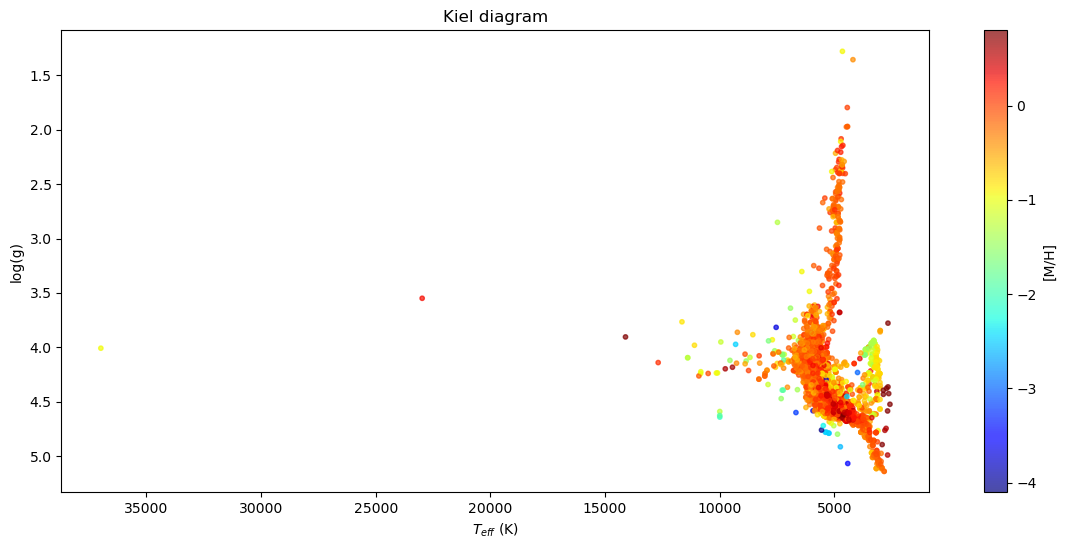

In [6]:
# Make sure there are no 'None' or '--' values in the data, as these cannot be plotted
matched_catalogue_full_clean = matched_catalogue_full[
    (matched_catalogue_full['logg'] != '--') & 
    (matched_catalogue_full['T_eff'] != '--') & 
    (matched_catalogue_full['[M/H]'] != '--')]

# Convert the relevant columns to numeric type
matched_catalogue_full_clean.loc[:, 'logg'] = pd.to_numeric(matched_catalogue_full_clean['logg'], errors='coerce')
matched_catalogue_full_clean.loc[:, 'T_eff'] = pd.to_numeric(matched_catalogue_full_clean['T_eff'], errors='coerce')
matched_catalogue_full_clean.loc[:, '[M/H]'] = pd.to_numeric(matched_catalogue_full_clean['[M/H]'], errors='coerce')

plt.figure(figsize=(14, 6))
scatter = plt.scatter(matched_catalogue_full_clean['T_eff'], matched_catalogue_full_clean['logg'], c=matched_catalogue_full_clean['[M/H]'], cmap='jet', s=10, alpha=0.7)
plt.colorbar(scatter, label='[M/H]')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$ (K)')
plt.ylabel('log(g)')
plt.title('Kiel diagram')
# plt.xlim([15000,0])
plt.show()

In [5]:
# Sort by T_eff in descending order
sorted_df = matched_catalogue_full_clean.sort_values(by='T_eff', ascending=False)

# Get the first and second rows with the highest values
first_max_teff_row = sorted_df.iloc[0]  # First highest value
second_max_teff_row = sorted_df.iloc[1]  # Second highest value

# Extract the T_eff values and the corresponding source_id
first_max_teff = first_max_teff_row['T_eff']
first_max_source_id = first_max_teff_row['source_id']
first_max_teff_exoplanet_eu = first_max_teff_row['star_teff']

second_max_teff = second_max_teff_row['T_eff']
second_max_source_id = second_max_teff_row['source_id']
second_max_teff_exoplanet_eu = second_max_teff_row['star_teff']

# Print the results
print(f"The highest value of T_eff is {first_max_teff} and the corresponding Gaia source_id is {first_max_source_id} (exoplanet.eu teff = {first_max_teff_exoplanet_eu}).")
print(f"The second highest value of T_eff is {second_max_teff} and the corresponding Gaia source_id is {second_max_source_id} (exoplanet.eu teff = {second_max_teff_exoplanet_eu}).")

The highest value of T_eff is 36984.51 and the corresponding Gaia source_id is 5966221298030125056 (exoplanet.eu teff = 26000.0).
The second highest value of T_eff is 22974.4 and the corresponding Gaia source_id is 5971244451311982336 (exoplanet.eu teff = 21700.0).


In [6]:
# Count the planets that have simultaneous values for [M/H], T_eff, and logg in the full catalog
planets_with_values_full = matched_catalogue_full[
    (matched_catalogue_full['logg'] != '--') &
    (matched_catalogue_full['T_eff'] != '--') &
    (matched_catalogue_full['[M/H]'] != '--')
]

# Print the number of planets with valid values in the three columns in the full catalog
print(f"Number of planets with metallicity, temperature, and logg: {len(planets_with_values_full)}")

# Count the points represented
num_points = len(matched_catalogue_full_clean)
print(f"{num_points} points are being represented in the plot.")

Number of planets with metallicity, temperature, and logg: 6243
6243 points are being represented in the plot.


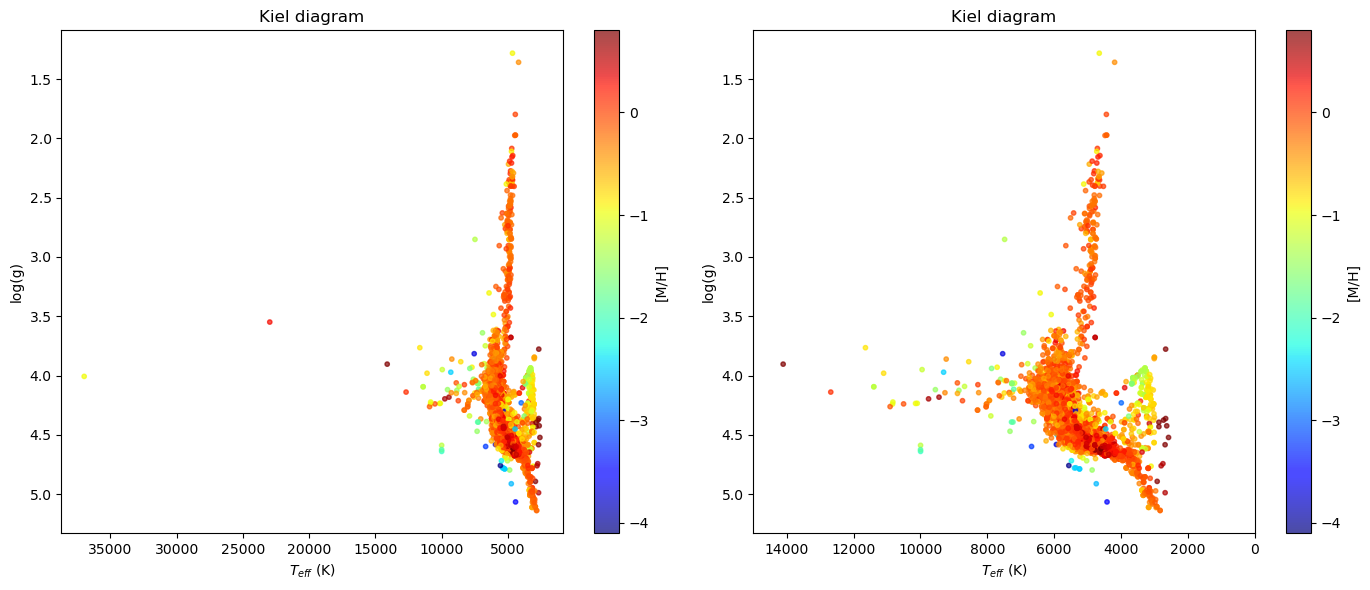

In [7]:
# Make sure there are no 'None' or '--' values in the data, as these cannot be plotted
matched_catalogue_full_clean = matched_catalogue_full[
    (matched_catalogue_full['logg'] != '--') & 
    (matched_catalogue_full['T_eff'] != '--') & 
    (matched_catalogue_full['[M/H]'] != '--')]

# Convert the relevant columns to numeric type
matched_catalogue_full_clean.loc[:, 'logg'] = pd.to_numeric(matched_catalogue_full_clean['logg'], errors='coerce')
matched_catalogue_full_clean.loc[:, 'T_eff'] = pd.to_numeric(matched_catalogue_full_clean['T_eff'], errors='coerce')
matched_catalogue_full_clean.loc[:, '[M/H]'] = pd.to_numeric(matched_catalogue_full_clean['[M/H]'], errors='coerce')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot (without xlim)
scatter_left = axes[0].scatter(matched_catalogue_full_clean['T_eff'], matched_catalogue_full_clean['logg'], 
                               c=matched_catalogue_full_clean['[M/H]'], cmap='jet', s=10, alpha=0.7)
axes[0].set_xlabel(r'$T_{eff}$ (K)')
axes[0].set_ylabel('log(g)')
axes[0].set_title('Kiel diagram')
plt.colorbar(scatter_left, ax=axes[0], label='[M/H]')
axes[0].invert_xaxis()
axes[0].invert_yaxis()

# Right plot (with xlim)
scatter_right = axes[1].scatter(matched_catalogue_full_clean['T_eff'], matched_catalogue_full_clean['logg'], 
                                c=matched_catalogue_full_clean['[M/H]'], cmap='jet', s=10, alpha=0.7)
axes[1].set_xlabel(r'$T_{eff}$ (K)')
axes[1].set_ylabel('log(g)')
axes[1].set_title('Kiel diagram')
plt.colorbar(scatter_right, ax=axes[1], label='[M/H]')
axes[1].invert_xaxis()
axes[1].invert_yaxis()
axes[1].set_xlim([15000, 0])  # Apply xlim to the right plot
plt.tight_layout()
plt.show()

# Star Age (exoplanet.eu)

First, we would like to check the age values we have available in the exoplanet.eu catalog:

In [8]:
star_age_count = matched_catalogue_full['star_age'].count()
star_age_error_min_count = matched_catalogue_full['star_age_error_min'].count()
star_age_error_max_count = matched_catalogue_full['star_age_error_max'].count()

print(f"Number of stars with star_age: {star_age_count}")
print(f"Number of stars with star_age_error_min: {star_age_error_min_count}")
print(f"Number of stars with star_age_error_max: {star_age_error_max_count}")

Number of stars with star_age: 3622
Number of stars with star_age_error_min: 3210
Number of stars with star_age_error_max: 3210


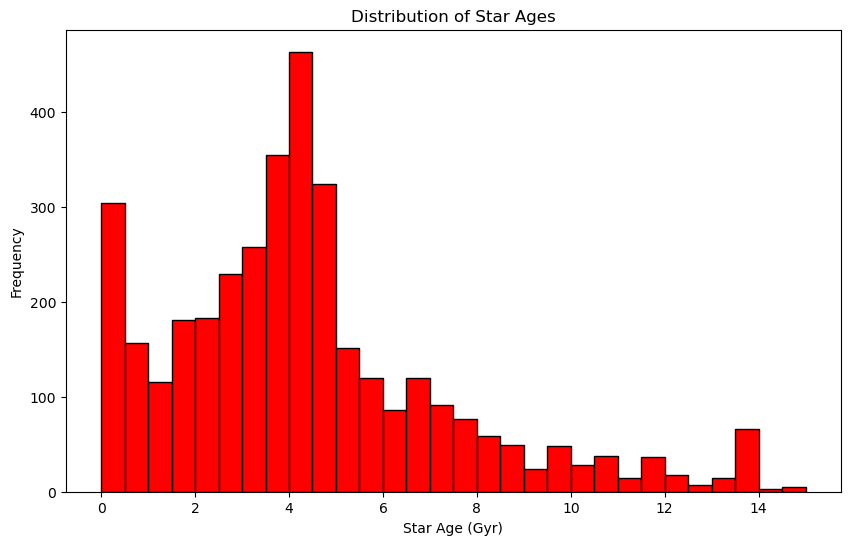

In [ ]:
valid_star_ages = matched_catalogue_full['star_age'][~matched_catalogue_full['star_age'].isna() & (matched_catalogue_full['star_age'] != '--')]

plt.figure(figsize=(10, 6))
plt.hist(valid_star_ages, bins=30, color='red', edgecolor='black')
plt.title('Distribution of Star Ages')
plt.xlabel('Star Age (Gyr)')
plt.ylabel('Frequency')
plt.show()

In [78]:
# Total number of exoplanets in the catalogue
total_exoplanets = len(matched_catalogue_full)

# Count the number of free-floating exoplanets (where 'star_name' is NaN)
free_floating_exoplanets = matched_catalogue_full['star_name'].isna().sum()

# Number of possible matches (excluding free-floating exoplanets)
possible_matches = total_exoplanets - free_floating_exoplanets

print(f"Total number of exoplanets in the catalogue: {total_exoplanets}")
print(f"Number of free floating exoplanets: {free_floating_exoplanets}")
print(f"Number of possible matches: {possible_matches}\n")

# Count the number of planets with 'cross-match' set to True and False
true_count = matched_catalogue_full['cross-match'].sum()
false_count = (~matched_catalogue_full['cross-match']).sum()

# Adjust the count of planets with Gaia identifier not found by excluding free-floating exoplanets
false_count_adjusted = false_count - free_floating_exoplanets

print(f"Gaia identifier found in SIMBAD: {true_count} planets.")
print(f"Gaia identifier not found in SIMBAD: {false_count_adjusted} planets.\n")

# Filter the rows where 'cross-match' is True
true_crossmatch_data = matched_catalogue_full[matched_catalogue_full['cross-match'] == True]

# Columns to check for numerical values
columns_to_check = ['parallax', 'parallax error', 'RV', 'RV error', '[M/H]', '[M/H] lower', '[M/H] upper']

# Function to count valid numerical values in a column (excluding NaN and '--')
def count_valid_values(column):
    return column[~column.isna() & (column != '--')].count()

# Count valid values in each selected column
valid_counts = {col: count_valid_values(true_crossmatch_data[col]) for col in columns_to_check}

# Print the results in the requested format
print("Planets with 'cross-match' set to True having numerical values for the added columns:")
for col, count in valid_counts.items():
    print(f" - {col}: {count} planets.")

# Count how many planets have values for 'parallax', 'RV', and '[M/H]'
planets_with_all_values = (true_crossmatch_data[['parallax', 'RV', '[M/H]']]
                           .apply(lambda row: all(pd.notna(row) & (row != '--')), axis=1)).sum()

print(f"\nPlanets with parallax, RV, and [M/H] values found: {planets_with_all_values} planets.\n")

# Count the number of non-null values in the star_age-related columns
star_age_count = matched_catalogue_full['star_age'].count()
star_age_error_min_count = matched_catalogue_full['star_age_error_min'].count()
star_age_error_max_count = matched_catalogue_full['star_age_error_max'].count()

print(f"Number of stars with star_age: {star_age_count}")
print(f"Number of stars with star_age_error_min: {star_age_error_min_count}")
print(f"Number of stars with star_age_error_max: {star_age_error_max_count}\n")

# Count how many planets have parallax, RV, [M/H], and star_age
planets_with_parallax_rv_mh_star_age = (true_crossmatch_data[['parallax', 'RV', '[M/H]', 'star_age']]
                                        .apply(lambda row: all(pd.notna(row) & (row != '--')), axis=1)).sum()

print(f"Planets with parallax, RV, [M/H], and star_age: {planets_with_parallax_rv_mh_star_age} planets.")

# Count how many planets have parallax, RV, [M/H], star_age, star_age_error_min, and star_age_error_max
planets_with_all_age_values = (true_crossmatch_data[['parallax', 'RV', '[M/H]', 'star_age', 
                                                     'star_age_error_min', 'star_age_error_max']]
                               .apply(lambda row: all(pd.notna(row) & (row != '--')), axis=1)).sum()

print(f"Planets with parallax, RV, [M/H], star_age, star_age_error_min and star_age_error_max: {planets_with_all_age_values} planets.")

Total number of exoplanets in the catalogue: 7380
Number of free floating exoplanets: 777
Number of possible matches: 6603

Gaia identifier found in SIMBAD: 6292 planets.
Gaia identifier not found in SIMBAD: 311 planets.

Planets with 'cross-match' set to True having numerical values for the added columns:
 - parallax: 6220 planets.
 - parallax error: 6220 planets.
 - RV: 4516 planets.
 - RV error: 4516 planets.
 - [M/H]: 5155 planets.
 - [M/H] lower: 5155 planets.
 - [M/H] upper: 5155 planets.

Planets with parallax, RV, and [M/H] values found: 3896 planets.

Number of stars with star_age: 3622
Number of stars with star_age_error_min: 3210
Number of stars with star_age_error_max: 3210

Planets with parallax, RV, [M/H], and star_age: 2283 planets.
Planets with parallax, RV, [M/H], star_age, star_age_error_min, and star_age_error_max: 2028 planets.


We lose too many stars if we use the age values from exoplanet.eu. Therefore, we try to cross-match our exoplanet catalogue with 2MASS and AIIWise to get age estimations for as many stars as possible in our sample of 3896 exoplanets, for which we have parallax, RV and [M/H] values.

# Star age (2MASS and AIIWise)

Continue this in Notebook N4

Then TOPCAT